In [183]:
# -*- coding: utf-8 -*-
"""
Created on Wed Mar 18 17:48:15 2020

@author: hhells
"""

# Import libraries
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import itertools
import argparse
import sys
import time
from sklearn import preprocessing
import pandas as pd
import os
import glob
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

## Preprocessing of data
# Function to load data

def get_power_data():
    """
    Read the Individual household electric power consumption dataset
    """
    
    # Assume that the dataset is located on folder "data"
    data = pd.read_csv('data/household_power_consumption.txt',
                       sep=';', low_memory=False)

    # Drop some non-predictive variables
    data = data.drop(columns=['Date', 'Time'], axis=1)

    #print(data.head())

    # Replace missing values
    data = data.replace('?', np.nan)

    # Drop NA
    data = data.dropna(axis=0)

    # Normalize
    standard_scaler = preprocessing.StandardScaler()
    np_scaled = standard_scaler.fit_transform(data)
    data = pd.DataFrame(np_scaled)

    # Goal variable assumed to be the first
    X = data.values[:, 1:].astype('float32')
    y = data.values[:, 0].astype('float32')

    # Create categorical y for binary classification with balanced classes
    y = np.sign(y+0.46)

    # Split train and test data here: (X_train, Y_train, X_test, Y_test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    no_class = 2                 #binary classification

    return X_train, X_test, y_train, y_test, no_class

def get_greenhouse_data():
    path = 'data/ghg_data/'
    all_files = glob.glob(path + "/*.dat")

    li = []

    for filename in all_files:
        df = pd.read_csv(filename, index_col=None,delimiter = " ",header = None)
        li.append(df)
    new_frame = pd.concat(li, axis=1, ignore_index=True)
    new_frame = new_frame.dropna(axis="rows")
    new_frame = new_frame.T     

    # Uncomment to compute correlation
    #N = 10000
    #df_corr = frame[0:N].apply(pd.to_numeric, errors='coerce', axis=1)
    #print(abs(df_corr.corr(method ='pearson')).sum(axis = 0))
    #print(np.argmax(abs(df_corr.corr(method ='pearson')).sum(axis = 0)))
    y_col = 15
    X_col = new_frame.columns.delete(y_col)

    col = np.append(X_col,y_col)
    df = new_frame[col].astype(np.float64)
    X = np.array(df[X_col])
    y = np.array(df[y_col])
    l = 0.01 
    Lambda = l*np.eye(X.shape[1], dtype=float)
    N = len(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    no_class = 2 #binary classification
    
    return X_train, X_test, y_train, y_test, no_class

X_train, X_test, y_train, y_test, no_class = get_greenhouse_data()
print("X,y types: {} {}".format(type(X_train), type(y_train)))
print("X size {}".format(X_train.shape))
print("Y size {}".format(y_train.shape))
print("one X vector: " + str(X_train[5,:]))

# Create a binary variable from one of the columns.
# You can use this OR not
th = 27.3
idx = y_train >= th
notidx = y_train < th
y_train[idx] = 1
y_train[notidx] = -1

# Sigmoid function
def sigmoid(x, derivative=False):
    sigm = 1. / (1. + np.exp(-x))
    if derivative:
        return sigm * (1. - sigm)
    return sigm

# Define weights initialization
def initialize_w(N, d):
    return 2*np.random.random((N,d)) - 1

# Fill in feed forward propagation
def feed_forward_propagation(X, y, W_1, W_2, w_3):
    # Fill in    
    layer_0 = X
    layer_1 = sigmoid(np.matmul(layer_0, W_1))
    layer_2 = sigmoid(np.matmul(layer_1, W_2))
    layer_3 = sigmoid(np.matmul(layer_2, w_3[:,0]))
    
    return layer_0, layer_1, layer_2, layer_3
    
# Fill in backpropagation    
def back_propagation(y, W_1, W_2, w_3, layer_0, layer_1, layer_2, layer_3):
    # Calculate the gradient here
    #Layer 3
    derC_a = 2*(layer_3-y)
    z_3 = np.matmul(layer_2,w_3)[:,0]
    derSigmoid = sigmoid(z_3, True)
    layer_3_delta = np.multiply(derC_a, derSigmoid)
    #Reshape layer_3_delta from (N,) to (N,1)
    layer_3_delta = (np.array(np.asmatrix(layer_3_delta))).T
    #Backpropagate to layer 2
    weight_prod = np.matmul(layer_3_delta, w_3.T)
    z_2 = np.matmul(layer_1, W_2)
    derSigmoid = sigmoid(z_2, True)
    layer_2_delta = np.multiply(weight_prod, derSigmoid)
    #Backpropagate to layer 1
    weight_prod = np.matmul(layer_2_delta, W_2.T)
    z_1 = np.matmul(layer_0, W_1)
    derSigmoid = sigmoid(z_1, True)
    layer_1_delta = np.multiply(weight_prod, derSigmoid)
    
    return layer_1_delta, layer_2_delta, layer_3_delta

# Cost function
def cost(X, y, w_1, w_2, w_3, lmbda):
    N, d = X.shape
    a1,a2,a3,a4 = feed_forward_propagation(X,y,w_1,w_2,w_3)

    return np.linalg.norm(a4 - y,2) ** 2 / N

# Define SGD
def SGD(X, y, W_1, W_2, w_3, lmbda, learning_rate, batch_size):
    # Form batch
    random_rows = np.random.randint(0, X.shape[0], batch_size)
    X_batch = X[random_rows,:]
    y_batch = y[random_rows]
    
    layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X_batch, y_batch, W_1, W_2, w_3)
    layer_1_delta, layer_2_delta, layer_3_delta = back_propagation(y_batch, W_1, W_2, w_3, layer_0, layer_1, layer_2, layer_3)
    #Get cost derivatives with respect to weights
    w_3_delta = np.matmul(layer_2.T, layer_3_delta)/batch_size
    W_2_delta = np.matmul(layer_1.T, layer_2_delta)/batch_size
    W_1_delta = np.matmul(layer_0.T, layer_1_delta)/batch_size
    #Take SGD step
    W_1 = W_1 - learning_rate*W_1_delta
    W_2 = W_2 - learning_rate*W_2_delta
    w_3 = w_3 - learning_rate*w_3_delta
    
    return W_1, W_2, w_3

# Define SVRG here:
def SVRG(X, y, W_1, W_2, w_3, lmbda, learning_rate, T):
    # Calculate full gradient
    batch_size = X.shape[0]
    layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X, y, W_1, W_2, w_3)
    layer_1_delta, layer_2_delta, layer_3_delta = back_propagation(y, W_1, W_2, w_3, layer_0, layer_1, layer_2, layer_3)
    full_w_3_delta = np.matmul(layer_2.T, layer_3_delta)/batch_size
    full_W_2_delta = np.matmul(layer_1.T, layer_2_delta)/batch_size
    full_W_1_delta = np.matmul(layer_0.T, layer_1_delta)/batch_size
    # Store weights
    tilde_W_1 = W_1
    tilde_W_2 = W_2
    tilde_w_3 = w_3
    #Inner loop
    for i in range(T):    
        # Form batch
        batch_size = 1
        random_rows = np.random.randint(0, X.shape[0], batch_size)
        X_batch = X[random_rows,:]
        y_batch = y[random_rows]
        #Get cost derivatives with respect to current weights
        layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X_batch, y_batch, W_1, W_2, w_3)
        layer_1_delta, layer_2_delta, layer_3_delta = back_propagation(y_batch, W_1, W_2, w_3, layer_0, layer_1, layer_2, layer_3)
        w_3_delta = np.matmul(layer_2.T, layer_3_delta)/batch_size
        W_2_delta = np.matmul(layer_1.T, layer_2_delta)/batch_size
        W_1_delta = np.matmul(layer_0.T, layer_1_delta)/batch_size
        #Get cost derivatives with respect to stored weights
        layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X_batch, y_batch, tilde_W_1, tilde_W_2, tilde_w_3)
        layer_1_delta, layer_2_delta, layer_3_delta = back_propagation(y_batch, tilde_W_1, tilde_W_2, tilde_w_3, layer_0, layer_1, layer_2, layer_3)
        tilde_w_3_delta = np.matmul(layer_2.T, layer_3_delta)/batch_size
        tilde_W_2_delta = np.matmul(layer_1.T, layer_2_delta)/batch_size
        tilde_W_1_delta = np.matmul(layer_0.T, layer_1_delta)/batch_size
        #Take one step
        W_1 = W_1 - learning_rate*(W_1_delta-tilde_W_1_delta+full_W_1_delta)
        W_2 = W_2 - learning_rate*(W_2_delta-tilde_W_2_delta+full_W_2_delta)
        w_3 = w_3 - learning_rate*(w_3_delta-tilde_w_3_delta+full_w_3_delta)
        
    return W_1, W_2, w_3

# Define GD here:
def GD(X, y, W_1, W_2, w_3, learning_rate):
    batch_size = X.shape[0]  
    layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X, y, W_1, W_2, w_3)
    layer_1_delta, layer_2_delta, layer_3_delta = back_propagation(y, W_1, W_2, w_3, layer_0, layer_1, layer_2, layer_3)
    #Get cost derivatives with respect to weights
    w_3_delta = np.matmul(layer_2.T, layer_3_delta)/batch_size
    W_2_delta = np.matmul(layer_1.T, layer_2_delta)/batch_size
    W_1_delta = np.matmul(layer_0.T, layer_1_delta)/batch_size
    #Take SGD step
    W_1 = W_1 - learning_rate*W_1_delta
    W_2 = W_2 - learning_rate*W_2_delta
    w_3 = w_3 - learning_rate*w_3_delta
    
    return W_1, W_2, w_3

# Define Perturbed GD here:
def PGD(X, y, W_1, W_2, w_3, learning_rate, noise):
    batch_size = X.shape[0]  
    layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X, y, W_1, W_2, w_3)
    layer_1_delta, layer_2_delta, layer_3_delta = back_propagation(y, W_1, W_2, w_3, layer_0, layer_1, layer_2, layer_3)
    #Get cost derivatives with respect to weights
    w_3_delta = np.matmul(layer_2.T, layer_3_delta)/batch_size
    N, d = w_3_delta.shape
    w_3_delta = w_3_delta + np.random.normal(0, noise, (N,d))
    W_2_delta = np.matmul(layer_1.T, layer_2_delta)/batch_size
    N, d = W_2_delta.shape
    W_2_delta = W_2_delta + np.random.normal(0, noise, (N,d))
    W_1_delta = np.matmul(layer_0.T, layer_1_delta)/batch_size
    N, d = W_1_delta.shape
    W_1_delta = W_1_delta + np.random.normal(0, noise, (N,d))
    #Take SGD step
    W_1 = W_1 - learning_rate*W_1_delta
    W_2 = W_2 - learning_rate*W_2_delta
    w_3 = w_3 - learning_rate*w_3_delta
    
    return W_1, W_2, w_3

# Define BCD here:
def BCD(X, y, W_1, W_2, w_3, learning_rate, num_w, block_size):
    batch_size = X.shape[0]  
    layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X, y, W_1, W_2, w_3)
    layer_1_delta, layer_2_delta, layer_3_delta = back_propagation(y, W_1, W_2, w_3, layer_0, layer_1, layer_2, layer_3)
    #Get cost derivatives with respect to weights
    w_3_delta = np.matmul(layer_2.T, layer_3_delta)/batch_size
    W_2_delta = np.matmul(layer_1.T, layer_2_delta)/batch_size
    W_1_delta = np.matmul(layer_0.T, layer_1_delta)/batch_size
    #Form coordinate block
    zero_blocks = np.random.choice(range(num_w), size=num_w-block_size, replace=False)
    for i in zero_blocks:
        if i<W_1.shape[0]*W_1_delta.shape[1]:
            row=(i)%(W_1_delta.shape[0])
            column = 0
            temp = i-W_1_delta.shape[0]
            while temp >= 0:
                column = column + 1
                temp = temp-W_1_delta.shape[0]
            W_1_delta[row,column] = 0
        elif i<W_2_delta.shape[0]*W_2_delta.shape[1]:
            i = i-W_1_delta.shape[0]*W_1_delta.shape[1]
            row=(i)%(W_2_delta.shape[0])
            column = 0
            temp = i-W_2_delta.shape[0]
            while temp >= 0:
                column = column + 1
                temp = temp-W_2_delta.shape[0]
            W_2_delta[row,column] = 0
        else:
            i = i-W_1_delta.shape[0]*W_1_delta.shape[1]-W_2_delta.shape[0]*W_2_delta.shape[1]
            row=(i)%(w_3_delta.shape[0])
            column = 0
            temp = i-w_3_delta.shape[0]
            while temp >= 0:
                column = column + 1
                temp = temp-w_3_delta.shape[0]
            w_3_delta[row,column] = 0
    
    #Take SGD step
    W_1 = W_1 - learning_rate*W_1_delta
    W_2 = W_2 - learning_rate*W_2_delta
    w_3 = w_3 - learning_rate*w_3_delta
        
    return W_1, W_2, w_3

X,y types: <class 'numpy.ndarray'> <class 'numpy.ndarray'>
X size (716375, 15)
Y size (716375,)
one X vector: [1.244105e-01 1.992760e-03 3.123979e+00 9.434436e-03 1.238929e-04
 1.210868e-04 1.454291e-04 1.234782e-04 1.210802e-04 1.210887e-04
 1.210887e-04 1.210888e-04 1.210887e-04 1.210887e-04 3.653175e+00]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:112: RuntimeWarning: overflow encountered in exp


Running SGD


No handles with labels found to put in legend.


9 2 [0.90108853]


<Figure size 432x288 with 0 Axes>

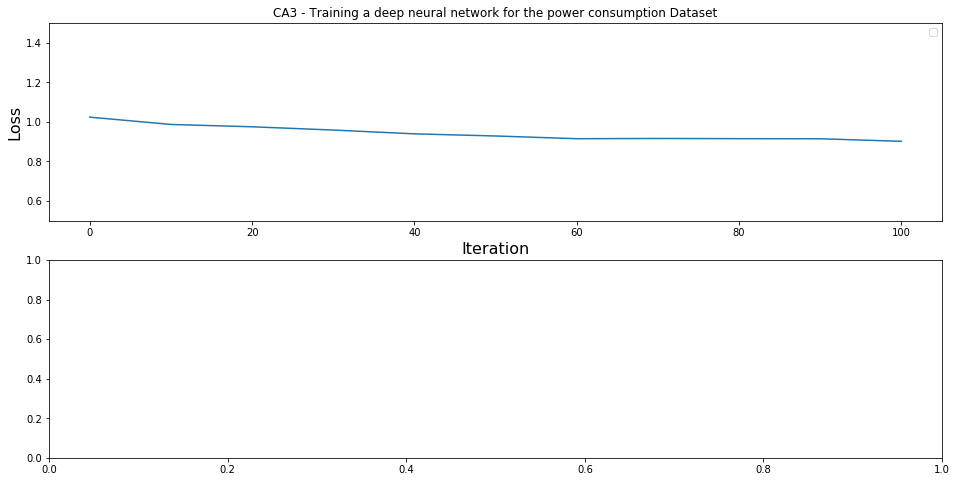

In [240]:
# Should be a hyperparameter that you tune, not an argument - Fill in the values
parser = argparse.ArgumentParser()
parser.add_argument('--lambda', type=float, default=0.1, dest='lmbda') 
parser.add_argument('--w_size', type=int, default=3, dest='w_size')
parser.add_argument('--lr', type=float, default=10)

# args = parser.parse_args()

#w_size_vec = [3,5,7,9]
#lamda_vec = [0.1]
#lr_vec = [0.01,0.5,2]
w_size_vec= [9]
lr_vec = [2]
plt.figure()
for w_size in w_size_vec:
    for lr in lr_vec:
        # Initialize weights and biases
        W_1 = initialize_w(X_train.shape[1], w_size)

        W_2 = initialize_w(w_size,w_size)

        w_3 = initialize_w(w_size, 1)

        num_w = X_train.shape[1]*w_size+w_size*w_size+w_size

        #Set params
        learning_rate = lr
        batch_size = 100
        lmbda = lamda

        # Define plotting variables
        fig, ax = plt.subplots(2, 1, figsize=(16, 8))

        T_svgr = 100
        T_gd = 100
        T_pgd = 100
        T_bcd = 100
        
        # Define the optimizers for the loop
        optimizers = [
                {# Fill in the hyperparameters
                    "name": "SGD",
                    "inner": 100,
                    "cost": np.zeros((11, 1)),
                    "time": np.zeros((11, 1)),
                    "iterations": np.zeros((11,1))
                },
                {# Fill in the hyperparameters
                    "name": "SVRG",
                    "inner": T_svgr,
                    "cost": np.zeros((T_svgr+1, 1)),
                    "time": np.zeros((T_svgr+1, 1)),
                    "iterations": np.zeros((T_svgr+1,1))
                },
                {# Fill in the hyperparameters
                    "name": "GD",
                    "inner": T_gd,
                    "cost": np.zeros((T_gd+1, 1)),
                    "time": np.zeros((T_gd+1, 1)),
                    "iterations": np.zeros((T_gd+1,1))
                },
                {# Fill in the hyperparameters
                    "name": "PGD",
                    "inner": T_pgd,
                    "cost": np.zeros((T_pgd+1, 1)),
                    "time": np.zeros((T_pgd+1, 1)),
                    "iterations": np.zeros((T_pgd+1,1))
                },
                {# Fill in the hyperparameters
                    "name": "BCD",
                    "inner": T_bcd,
                    "cost": np.zeros((T_bcd+1, 1)),
                    "time": np.zeros((T_bcd+1, 1)),
                    "iterations": np.zeros((T_bcd+1,1))
                }
            ]

        # Run the iterates over the algorithms above

        idx = -1
        #for opt in optimizers:
        #Change the index of optimizers[x] to plot a different optimizer. 0=SGD, 1=SVRG, 2=GD... Alternatively, replace with for loop in comment above to test all optimizers.
        curr_optimizer = 0
        if True==True:
            opt = optimizers[curr_optimizer]
            cost_idx = 0
            opt["cost"][cost_idx] = cost(X_train, y_train, W_1, W_2, w_3, 0)
            opt["time"][cost_idx] = 0
            W_1_train = W_1
            W_2_train = W_2
            w_3_train = w_3
            idx = idx + 1
            print("Running " + opt["name"])
            for i in range(opt["inner"]):
                start = time.time()
                if opt["name"] == "SGD":
                    W_1_train, W_2_train, w_3_train = SGD(X_train, y_train, W_1_train, W_2_train, w_3_train, lmbda, learning_rate, batch_size)
                    opt["iterations"]=range(0, 110, 10)
                    if i%10 == 9:
                        cost_idx = cost_idx + 1
                        opt["cost"][cost_idx] = cost(X_train, y_train, W_1_train, W_2_train, w_3_train, 0)
                        opt["time"][cost_idx] = opt["time"][cost_idx-1] + time.time()-start
                if opt["name"] == "SVRG":
                    T = 10
                    W_1_train, W_2_train, w_3_train = SVRG(X_train, y_train, W_1_train, W_2_train, w_3_train, lmbda, learning_rate/2, T)
                    cost_idx = cost_idx + 1
                    opt["iterations"]=range(T_svgr+1)
                    opt["cost"][cost_idx] = cost(X_train, y_train, W_1_train, W_2_train, w_3_train, 0)
                    opt["time"][cost_idx] = opt["time"][cost_idx-1] + time.time()-start
                if opt["name"] == "GD":
                    W_1_train, W_2_train, w_3_train = GD(X_train, y_train, W_1_train, W_2_train, w_3_train, learning_rate*2)
                    cost_idx = cost_idx + 1
                    opt["iterations"]=range(T_gd+1)
                    opt["cost"][cost_idx] = cost(X_train, y_train, W_1_train, W_2_train, w_3_train, 0)
                    opt["time"][cost_idx] = opt["time"][cost_idx-1] + time.time()-start
                if opt["name"] == "PGD":
                    W_1_train, W_2_train, w_3_train = PGD(X_train, y_train, W_1_train, W_2_train, w_3_train, learning_rate*2, 0.01)
                    cost_idx = cost_idx + 1
                    opt["iterations"]=range(T_pgd+1)
                    opt["cost"][cost_idx] = cost(X_train, y_train, W_1_train, W_2_train, w_3_train, 0)
                    opt["time"][cost_idx] = opt["time"][cost_idx-1] + time.time()-start
                if opt["name"] == "BCD":
                    W_1_train, W_2_train, w_3_train = BCD(X_train, y_train, W_1_train, W_2_train, w_3_train, learning_rate*2, num_w, 15)
                    cost_idx = cost_idx + 1
                    opt["iterations"]=range(T_bcd+1)
                    opt["cost"][cost_idx] = cost(X_train, y_train, W_1_train, W_2_train, w_3_train, 0)
                    opt["time"][cost_idx] = opt["time"][cost_idx-1] + time.time()-start
            print(w_size,lr,optimizers[curr_optimizer]["cost"][-1])
        ax[0].legend(loc="upper right")
        ax[0].set_xlabel(r"Iteration", fontsize=16)
        ax[0].set_ylabel("Loss", fontsize=16)
        ax[0].set_title("CA3 - Training a deep neural network for the power consumption Dataset")
        ax[0].set_ylim(ymin=0.5)
        ax[0].set_ylim(ymax=1.5)

        #ax[1].legend(loc="upper right")
        #ax[1].set_xlabel(r"Time [s]", fontsize=16)
        #ax[1].set_ylabel("Loss", fontsize=16)
        #ax[1].set_ylim(ymin=0.5)
        #ax[1].set_ylim(ymax=1.5)

        opt = optimizers[curr_optimizer]
        plotcost = opt["cost"]
        iterations = opt["iterations"]
        ax[0].plot(iterations, plotcost)

        #plottime = opt["time"]
        #ax[1].plot(plottime, plotcost)

        plt.savefig("power.png")

    